## Probability Threshold Moving
- The default threshold for interpreting probabilities to class labels is 0.5, and tuning this
hyperparameter is called threshold moving.
- How to calculate the optimal threshold for the ROC Curve and Precision-Recall Curve
directly.
- How to manually search threshold values for a chosen model and model evaluation metric.

### Optimal Threshold for ROC Curve
The curve is useful to understand the trade-off in the true-positive rate and false-positive
rate for different thresholds. The area under the ROC Curve, so-called ROC AUC, provides
a single number to summarize the performance of a model in terms of its ROC Curve with a
value between 0.5 (no-skill) and 1.0 (perfect skill). The ROC Curve is a useful diagnostic tool
for understanding the trade-off for different thresholds and the ROC AUC provides a useful
number for comparing models based on their general capabilities.

One approach would be to test the model with each threshold returned from the call
roc auc score() and select the threshold with the largest G-mean value. Given that we
have already calculated the Sensitivity (TPR) and the complement to the Specificity when we
calculated the ROC Curve, we can calculate the G-mean for each threshold directly.

 Best Threshold=0.016153, G-mean=0.933 


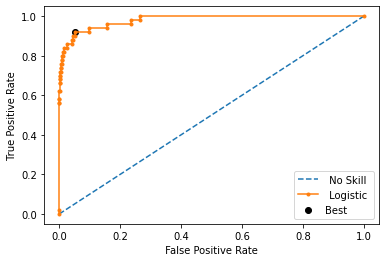

In [4]:
# roc curve for logistic regression model
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2,
stratify=y)
# fit a model
model = LogisticRegression(solver= 'lbfgs' )
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print( ' Best Threshold=%f, G-mean=%.3f ' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle= '--' , label= ' No Skill ' )
pyplot.plot(fpr, tpr, marker= '.' , label= ' Logistic ' )
pyplot.scatter(fpr[ix], tpr[ix], marker= 'o' , color= 'black' , label= 'Best' )
# axis labels
pyplot.xlabel( ' False Positive Rate ' )
pyplot.ylabel( ' True Positive Rate ' )
pyplot.legend()
# show the plot
pyplot.show()

 Best Threshold=0.256036, F-measure=0.756 


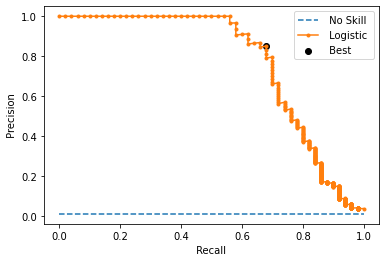

In [5]:
# optimal threshold for precision-recall curve with logistic regression model
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2,
stratify=y)
# fit a model
model = LogisticRegression(solver= 'lbfgs' )
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f-measure
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f-measure
ix = argmax(fscore)
print( ' Best Threshold=%f, F-measure=%.3f ' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle= '--' , label= ' No Skill ' )
pyplot.plot(recall, precision, marker= '.' , label= ' Logistic ' )
pyplot.scatter(recall[ix], precision[ix], marker= 'o' , color= 'black' , label= ' Best ' )
# axis labels
pyplot.xlabel( ' Recall ' )
pyplot.ylabel( ' Precision ' )
pyplot.legend()
# show the plot
pyplot.show()

### Optimal Threshold Tuning
Sometimes, we simply have a model and we wish to know the best threshold directly. In this
case, we can define a set of thresholds and then evaluate predicted probabilities under each in
order to find and select the optimal threshold. We can demonstrate this with a worked example.

In [6]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
  return (pos_probs >= threshold).astype( 'int' )
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2,
stratify=y)
# fit a model
model = LogisticRegression(solver= 'lbfgs' )
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(testy, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print( ' Threshold=%.3f, F-measure=%.5f ' % (thresholds[ix], scores[ix]))

 Threshold=0.251, F-measure=0.75556 


## Probability Calibration
- Calibrated probabilities are required to get the most out of models for imbalanced
classification problems.
- How to calibrate predicted probabilities for nonlinear models like SVMs, decision trees,
and KNN.
- How to grid search different probability calibration methods on a dataset with a skewed
class distribution.

### Problem of Uncalibrated Probabilities
As such, using machine learning models that predict probabilities is generally preferred when
working on imbalanced classification tasks. The problem is that few machine learning models
have calibrated probabilities.

Calibrated probabilities means that the probability reflects the likelihood of true events. This
might be confusing if you consider that in classification, we have class labels that are correct or
not instead of probabilities. To clarify, recall that in binary classification, we are predicting a
negative or positive case as class 0 or 1. If 100 examples are predicted with a probability of
0.8, then 80 percent of the examples will have class 1 and 20 percent will have class 0, if the
probabilities are calibrated. 

- Calibrated Probabilities. Probabilities match the true likelihood of events.
- Uncalibrated Probabilities. Probabilities are over-confident and/or under-confident.

### SVM With Calibrated Probabilities

We will define the SVM model as before, then define
the CalibratedClassifierCV with isotonic regression, then evaluate the calibrated model via
repeated stratified k-fold cross-validation.

In [ ]:
# evaluate weighted svm with calibrated probabilities for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# define model
model = SVC(gamma= 'scale' , class_weight= 'balanced' )
#model = DecisionTreeClassifier()

# wrap the model
calibrated = CalibratedClassifierCV(model, method= 'isotonic' , cv=3)
#calibrated = CalibratedClassifierCV(model, method= ' sigmoid ' , cv=3)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X, y, scoring= ' roc_auc ' , cv=cv, n_jobs=-1)
# summarize performance
print( ' Mean ROC AUC: %.3f ' % mean(scores))

### Grid Search Probability Calibration With KNN
The k-nearest neighbor, or KNN, algorithm is another nonlinear machine learning algorithm
that predicts a class label directly and must be modified to produce a probability-like score.
This often involves using the distribution of class labels in the neighborhood.

In [8]:
# grid search probability calibration with knn for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# define model
model = KNeighborsClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model)
# define grid
param_grid = dict(cv=[2,3,4], method=[ 'sigmoid' , 'isotonic' ])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=calibrated, param_grid=param_grid, n_jobs=-1, cv=cv,
scoring= 'roc_auc' )
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print( ' Best: %f using %s ' % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]
for mean, stdev, param in zip(means, stds, params):
  print( ' %f (%f) with: %r ' % (mean, stdev, param))

 Best: 0.895029 using {'cv': 2, 'method': 'sigmoid'} 
 0.895029 (0.066617) with: {'cv': 2, 'method': 'sigmoid'} 
 0.893549 (0.065846) with: {'cv': 2, 'method': 'isotonic'} 
 0.886835 (0.070207) with: {'cv': 3, 'method': 'sigmoid'} 
 0.885104 (0.071671) with: {'cv': 3, 'method': 'isotonic'} 
 0.885167 (0.071732) with: {'cv': 4, 'method': 'sigmoid'} 
 0.877146 (0.077137) with: {'cv': 4, 'method': 'isotonic'} 
